# Sentiment Analysis of Amazon Fine Food Reviews using LSTM

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Loading the Dataset

In [2]:
df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


**Add labels to reviews according to score values**
* Drop the reviews with score 3. (neutral)
* Those with a score value of 5 and 4 are labeled as positive, ie 1.
* Those with a score value of 1 and 2 are labeled negative, ie 0.

In [3]:
df=df[['Text','Score']]
df['review']=df['Text']
df['label']=df['Score']
df.drop(['Text','Score'],axis=1,inplace=True)
df.head()
df = df[df['label'] != 3]  # drop rating values 3 reviews, neutral reviews

def mark_sentiment(rating):
    if(rating<3):
        return 0 # negative 
    else:
        return 1 # positive
df['label']=df['label'].apply(mark_sentiment)

# check missing value and duplicates
print(df['label'].isnull().sum())
df['review'].isnull().sum() 
df.drop_duplicates(subset=['label','review'],keep='first',inplace=True) 

0


**Select balanced 20000 reviews**

In [4]:
pos_df=df.loc[df.label==1,:][:10000]
neg_df=df.loc[df.label==0,:][:10000]
df=pd.concat([pos_df,neg_df],ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True) #perform a random shuffle. It's a good practice to shuffle the data before splitting between a train and test set. That way the sentiment classes are equally distributed over the train and test sets. df = df.reindex(np.random.permutation(df.index))  
df.head()

,review,label
0,I really like the wild ride jerky. Very good ...,0
1,If you love Pork Rinds then these are the thin...,1
2,We bought both brands to try and found this on...,0
3,This powder is actually very good and this wou...,0
4,"No expiration date on bottle. Oil hard, had t...",0


**Data Distribution**

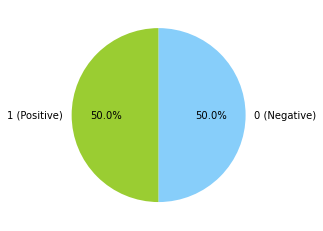

In [5]:
pie_label = ["1 (Positive)","0 (Negative)"]
pie_colors = ["yellowgreen", "lightskyblue"]
plt.pie(df.label.value_counts(), labels=pie_label, colors=pie_colors, startangle=90, autopct='%.1f%%')
plt.show()

# Data Preprocesing

In [6]:
df['review'] = df.review.apply(lambda x : x.lower())  # all reviews characters converts to lowercase
df['review'] = df.review.apply(lambda x: re.sub(r'\d+','', x))  # remove the numbers in reviews
df['review'] = df.review.apply(lambda x: re.sub(r'[^\w\s]', ' ',x)) # remove the punctuations in reviews
df['review'] = df.review.apply(lambda x: x.strip()) # remove whitespaces

# Preparing the Embedding Layer

**Tokenizing the dataset**

In [7]:
x = df['review']
y = df['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

tokenizer = Tokenizer(num_words=5000)  # Initialize the tokenizer with a 5000 word limit. This is the number of words we would like to encode.
tokenizer.fit_on_texts(x_train) # we call fit_on_texts to create associations of words and numbers 

# After having created the dictionary we can convert the text to a list of integer indexes.
# This is done with the text_to_sequences method of the Tokenizer.
# calling text_to_sequence replaces the words in a sentence with their respective associated numbers.
# This transforms each sentence into sequences of numbers.
x_train = tokenizer.texts_to_sequences(x_train) 
x_test = tokenizer.texts_to_sequences(x_test) 

**Padding the dataset**

In [8]:
# The reviews have different number of words, therefore, the length of the sequence of numbers will be different.
# Our model requires inputs to have equal lengths, so we will have to pad the sequence to have the chosen length of inputs.
# This is done by calling the pad_sequence method with a length of 200.
vocab_size = len(tokenizer.word_index) + 1
max_review_length = 200

x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)
print(x_train.shape)

(16000, 200)


# Model 1 
**Embedding -> LSTM -> Dense(Output(Sigmoid))**

In [9]:
# Build Model
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length =max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=5)
result = model.evaluate(x_test, y_test, verbose=0)
#Results
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16000 samples, validate on 4000 samples
Epoch 1/5
16000/16000 [==============================] - 50s 3ms/step - loss: 0.4887 - accuracy: 0.7490 - val_loss: 0.3130 - val_accuracy: 0.8675
Epoch 2/5
16000/16000 [==============================] - 47s 3ms/step - loss: 0.2475 - accuracy: 0.9045 - val_loss: 0.2869 - val_accuracy: 0.8860
Epoch 3/5
16000/16000 [==============================] - 49s 3ms/step - loss: 0.1982 - accuracy: 0.9262 - val_loss: 0.2909 - val_accuracy: 0.8878
Epoch 4/5
16000/16000 [==============================] - 50s 3ms/step - loss: 0.1722 - accuracy: 0.9369 - val_loss: 0.2984 - val_accuracy: 0.8848
Epoch 5/5
16000/16000 [==============================] - 49s 3ms/step - loss: 0.1535 - accuracy: 0.9447 - val_loss: 0.3333 - val_accuracy: 0.8687
Test Score: 0.33334745055437087
Test Accuracy: 0.8687499761581421
Accuracy: 86.87%


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


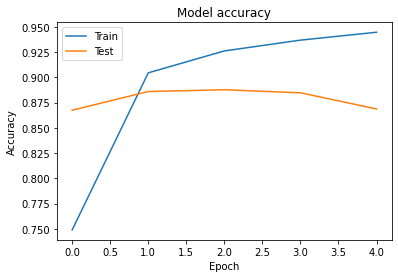

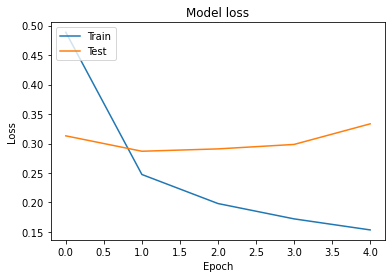

In [10]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model 2 
**Embedding -> LSTM -> Dense(Output(Sigmoid))**                                                        
**Same with Model 1 except optimization algorithm. In this study used Adadelta optimizer. With this model, the effect of optimization algorithm is observed.**


In [11]:
# Build Model
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length =max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='Adadelta', metrics=['accuracy'])

# Train Model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=5)
result = model.evaluate(x_test, y_test, verbose=0)
#Results
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Train on 16000 samples, validate on 4000 samples
Epoch 1/5
16000/16000 [==============================] - 48s 3ms/step - loss: 0.6900 - accuracy: 0.5532 - val_loss: 0.6605 - val_accuracy: 0.6867
Epoch 2/5
16000/16000 [==============================] - 49s 3ms/step - loss: 0.5516 - accuracy: 0.7144 - val_loss: 0.4876 - val_accuracy: 0.7785
Epoch 3/5
16000/16000 [==============================] - 48s 3ms/step - loss: 0.4182 - accuracy: 0.8123 - val_loss: 0.3497 - val_accuracy: 0.8482
Epoch 4/5
16000/16000 [==============================] - 48s 3ms/step - loss: 0.3466 - accuracy: 0.8529 - val_loss: 0.3931 - val_accuracy: 0.8288
Epoch 5/5
16000/16000 [==============================] - 47s 3ms/step - loss: 0.2999 - accuracy: 0.8769 - val_loss: 0.3202 - val_accuracy: 0.8677
Test Score: 0.3202390952706337
Test Accuracy: 0.8677499890327454
Accuracy: 86.77%


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


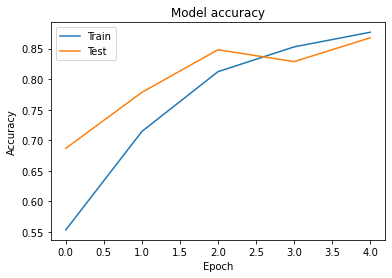

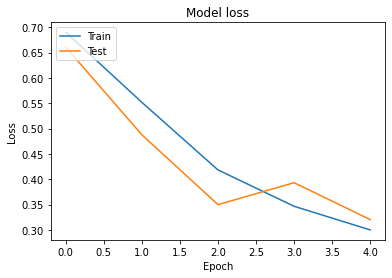

In [12]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model 3 
**Embedding -> LSTM -> Dense(Output(Sigmoid))**                                                          
**Same as Model 1, only batch_size different. With this model, the effect of batch size is observed.**

In [13]:
# Build Model
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length =max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256, epochs=5)
result = model.evaluate(x_test, y_test, verbose=0)
#Results
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Train on 16000 samples, validate on 4000 samples
Epoch 1/5
16000/16000 [==============================] - 41s 3ms/step - loss: 0.5757 - accuracy: 0.6973 - val_loss: 0.4415 - val_accuracy: 0.7968
Epoch 2/5
16000/16000 [==============================] - 41s 3ms/step - loss: 0.3202 - accuracy: 0.8673 - val_loss: 0.2910 - val_accuracy: 0.8780
Epoch 3/5
16000/16000 [==============================] - 41s 3ms/step - loss: 0.2235 - accuracy: 0.9144 - val_loss: 0.3006 - val_accuracy: 0.8752
Epoch 4/5
16000/16000 [==============================] - 41s 3ms/step - loss: 0.2018 - accuracy: 0.9264 - val_loss: 0.2976 - val_accuracy: 0.8800
Epoch 5/5
16000/16000 [==============================] - 41s 3ms/step - loss: 0.1693 - accuracy: 0.9397 - val_loss: 0.3038 - val_accuracy: 0.8790
Test Score: 0.30384171614050864
Test Accuracy: 0.8790000081062317
Accuracy: 87.90%


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


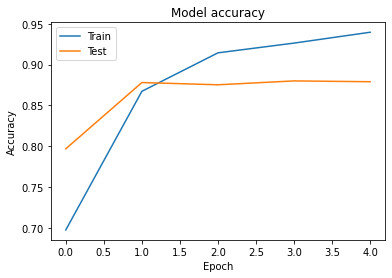

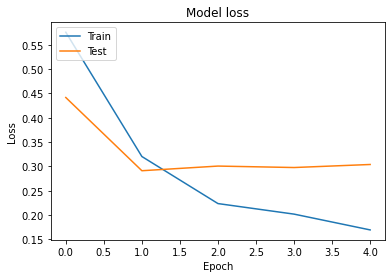

In [14]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model 4
**Embedding -> LSTM -> LSTM -> Dense(Output(Sigmoid))**

In [15]:
# Build Model
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length =max_review_length))
model.add(LSTM(100, return_sequences = True))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=5)
result = model.evaluate(x_test, y_test, verbose=0)
# Results
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Train on 16000 samples, validate on 4000 samples
Epoch 1/5
16000/16000 [==============================] - 107s 7ms/step - loss: 0.4844 - accuracy: 0.7548 - val_loss: 0.3380 - val_accuracy: 0.8572
Epoch 2/5
16000/16000 [==============================] - 103s 6ms/step - loss: 0.2556 - accuracy: 0.8992 - val_loss: 0.3117 - val_accuracy: 0.8690
Epoch 3/5
16000/16000 [==============================] - 102s 6ms/step - loss: 0.1971 - accuracy: 0.9256 - val_loss: 0.2976 - val_accuracy: 0.8808
Epoch 4/5
16000/16000 [==============================] - 103s 6ms/step - loss: 0.1724 - accuracy: 0.9368 - val_loss: 0.3236 - val_accuracy: 0.8763
Epoch 5/5
16000/16000 [==============================] - 102s 6ms/step - loss: 0.1557 - accuracy: 0.9432 - val_loss: 0.3412 - val_accuracy: 0.8788
Test Score: 0.3411714727580547
Test Accuracy: 0.8787500262260437
Accuracy: 87.88%


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


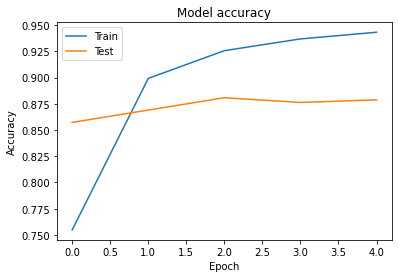

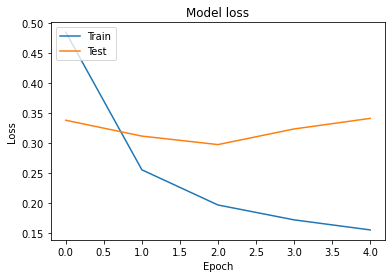

In [16]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model 5
**Embedding -> LSTM -> Dropout -> LSTM -> Dropout -> Dense(Output(Sigmoid))**

In [17]:
from keras.layers import Dropout
# Build Model
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length =max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train Model             
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=5)
result = model.evaluate(x_test, y_test, verbose=0)
# Results
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Train on 16000 samples, validate on 4000 samples
Epoch 1/5
16000/16000 [==============================] - 107s 7ms/step - loss: 0.4738 - accuracy: 0.7572 - val_loss: 0.3217 - val_accuracy: 0.8658
Epoch 2/5
16000/16000 [==============================] - 106s 7ms/step - loss: 0.2489 - accuracy: 0.9027 - val_loss: 0.2978 - val_accuracy: 0.8838
Epoch 3/5
16000/16000 [==============================] - 105s 7ms/step - loss: 0.2038 - accuracy: 0.9247 - val_loss: 0.3053 - val_accuracy: 0.8875
Epoch 4/5
16000/16000 [==============================] - 105s 7ms/step - loss: 0.1729 - accuracy: 0.9367 - val_loss: 0.3368 - val_accuracy: 0.8840
Epoch 5/5
16000/16000 [==============================] - 104s 6ms/step - loss: 0.1463 - accuracy: 0.9477 - val_loss: 0.3305 - val_accuracy: 0.8813
Test Score: 0.33051382103562355
Test Accuracy: 0.8812500238418579
Accuracy: 88.13%


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


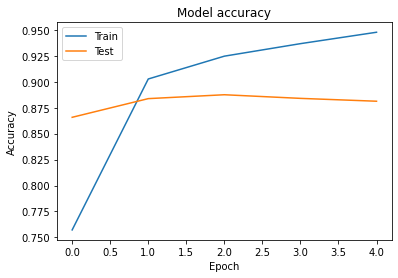

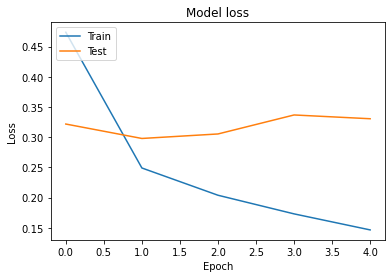

In [18]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model 6
**Embedding -> LSTM -> Dense(activation:Relu) -> Dense(Output(Sigmoid))**                             
**With this model, the effect of activation function is observed.**

In [19]:
# Build Model
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length =max_review_length))
model.add(LSTM(100))
model.add(Dense(64, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train Model             
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=5)
result = model.evaluate(x_test, y_test, verbose=0)
# Results
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Train on 16000 samples, validate on 4000 samples
Epoch 1/5
16000/16000 [==============================] - 48s 3ms/step - loss: 0.5069 - accuracy: 0.7387 - val_loss: 0.3349 - val_accuracy: 0.8537
Epoch 2/5
16000/16000 [==============================] - 48s 3ms/step - loss: 0.2693 - accuracy: 0.8923 - val_loss: 0.3008 - val_accuracy: 0.8727
Epoch 3/5
16000/16000 [==============================] - 47s 3ms/step - loss: 0.2040 - accuracy: 0.9244 - val_loss: 0.3055 - val_accuracy: 0.8740
Epoch 4/5
16000/16000 [==============================] - 47s 3ms/step - loss: 0.1732 - accuracy: 0.9365 - val_loss: 0.3072 - val_accuracy: 0.8785
Epoch 5/5
16000/16000 [==============================] - 50s 3ms/step - loss: 0.1543 - accuracy: 0.9439 - val_loss: 0.3317 - val_accuracy: 0.8668
Test Score: 0.33168102395534516
Test Accuracy: 0.8667500019073486
Accuracy: 86.68%


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


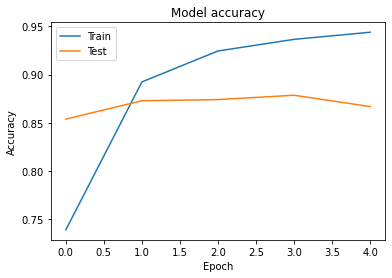

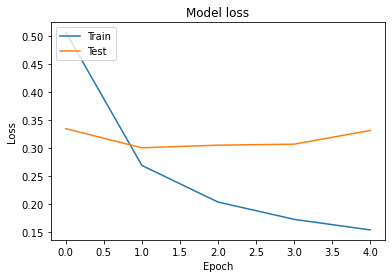

In [20]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model 7
**Embedding -> LSTM -> Dense(activation:Softmax) -> Dense(Output(Sigmoid))**                         
**With this model, the effect of activation function is observed.**

In [21]:
# Build Model
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length =max_review_length))
model.add(LSTM(100))
model.add(Dense(64, kernel_initializer='uniform', activation='softmax'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train Model             
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=5)
result = model.evaluate(x_test, y_test, verbose=0)
# Results
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Train on 16000 samples, validate on 4000 samples
Epoch 1/5
16000/16000 [==============================] - 47s 3ms/step - loss: 0.6919 - accuracy: 0.5424 - val_loss: 0.6965 - val_accuracy: 0.4958
Epoch 2/5
16000/16000 [==============================] - 47s 3ms/step - loss: 0.6937 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 3/5
16000/16000 [==============================] - 48s 3ms/step - loss: 0.6932 - accuracy: 0.4957 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 4/5
16000/16000 [==============================] - 47s 3ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 5/5
16000/16000 [==============================] - 47s 3ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5042
Test Score: 0.6931267328262329
Test Accuracy: 0.5042499899864197
Accuracy: 50.42%


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


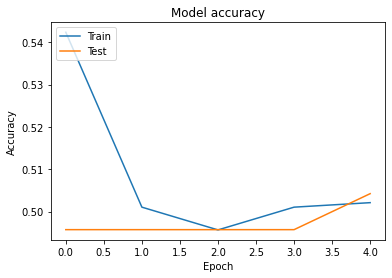

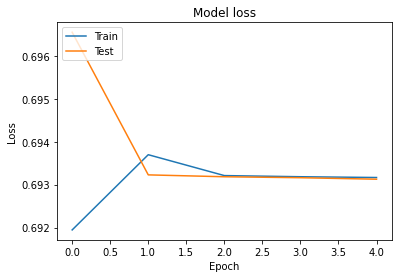

In [22]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()